# Trending Youtube Videos

In the initial phases of this project, we used the YouTube API alongside various AWS resources to construct a PostgreSQL database focused on trending videos, which undergoes automatic daily updates.

Each day, the database receives an automatic update consisting of 50 new rows which is the maximum number of videos available in the YouTube API's trending videos list. To achieve this, we utilize Amazon Lambda in conjunction with Amazon EventBridge Scheduler, triggering a Python function on a daily basis. This function employs the YouTube API to retrieve the trending videos list along with several key metrics associated with each video. Subsequently, the gathered data is recorded on a PostgreSQL database hosted on Amazon RDS.

The Python script that collects data within the Lambda function is contained as a separate file in this folder.

In this notebook, we will perform an exploratory analysis on this data set. We will address the following questions:

1. [Are there any particularly notable videos from the months we've been observing?](#section1)
2. [How are the variables correlated with each other?](#section2)
3. [Are there any time points where the variables fluctuated significantly?](#section3)
4. [Are there any particular days that stand out as optimal for video publishing?](#section4)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()

from sqlalchemy import create_engine, text
from configparser import ConfigParser

In [2]:
# Load database credentials from file
config = ConfigParser()
config.read('config.ini')

host = config.get('database', 'host')
user = config.get('database', 'user')
password = config.get('database', 'password')
database = config.get('database', 'database')
port = 5432

In [3]:
# Create a SQLAlchemy engine
db_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(db_url)

Our AWS script started inserting 50 trending videos daily on December 3, 2023. As of March 22, 2024, here is its current status.

Please note that both `video_id` and `trending_date` serve as primary keys (refer to lambda_function.py), so if a video remains in the trending videos list for multiple days, each occurrence is recorded."

In [4]:
query = """SELECT trending_date td, COUNT(*) entry_count,
        (SELECT COUNT(*) FROM youtube_metrics) total
        FROM youtube_metrics
        GROUP BY td
        ORDER BY td
        """
pd.read_sql_query(sql=text(query), con=engine.connect())

,td,entry_count,total
0,2023-12-03,50,5500
1,2023-12-04,50,5500
2,2023-12-05,50,5500
3,2023-12-06,50,5500
4,2023-12-07,50,5500
...,...,...,...
105,2024-03-18,50,5500
106,2024-03-19,50,5500
107,2024-03-20,50,5500
108,2024-03-21,50,5500


In [5]:
query = "SELECT * FROM youtube_metrics"
df = pd.read_sql(sql=text(query), con=engine.connect())

df.shape

(5500, 8)

In [6]:
df.head()

,video_id,trending_date,publish_date,title,duration,views,likes,comments
0,Wjij-OX9RKI,2023-12-03,2023-12-02,Fortnite Battle Royale Chapter 5 Launch Trailer,0 days 00:01:30,4874502,230120,16151
1,F9U-yoJbgWs,2023-12-03,2023-12-02,The Boys – Season 4 Official Teaser Trailer | ...,0 days 00:01:50,5944265,314273,11029
2,0kQ8i2FpRDk,2023-12-03,2023-12-02,Fallout - Teaser Trailer | Prime Video,0 days 00:02:34,4738672,140347,12927
3,HQ8H5gqGA34,2023-12-03,2023-12-02,House of the Dragon Season 2 | Official Teaser...,0 days 00:01:26,3250473,130514,4834
4,okvG6H0UaIs,2023-12-03,2023-12-02,Top 10 GIFS of ALL TIME,0 days 00:26:24,2063101,83318,3086


In [7]:
df.dtypes

video_id                  object
trending_date             object
publish_date              object
title                     object
duration         timedelta64[ns]
views                      int64
likes                      int64
comments                   int64
dtype: object

We'll change the date related columns to datetime and timedelta objects to be able to handle them more easily.

In [8]:
df['trending_date'] = pd.to_datetime(df['trending_date'])

In [9]:
df['publish_date'] = pd.to_datetime(df['publish_date'])

In [10]:
df['duration'] = df['duration'].apply(lambda t: pd.Timedelta(t))

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   video_id       5500 non-null   object         
 1   trending_date  5500 non-null   datetime64[ns] 
 2   publish_date   5500 non-null   datetime64[ns] 
 3   title          5500 non-null   object         
 4   duration       5500 non-null   timedelta64[ns]
 5   views          5500 non-null   int64          
 6   likes          5500 non-null   int64          
 7   comments       5500 non-null   int64          
dtypes: datetime64[ns](2), int64(3), object(2), timedelta64[ns](1)
memory usage: 343.9+ KB


When creating our database, we chose to enter -1 for the missing values obtained from YouTube API (refer to lambda_function.py).

In [12]:
# Missing entries in likes and comments
df[(df['likes'] == -1) | (df['comments'] == -1)]

,video_id,trending_date,publish_date,title,duration,views,likes,comments
279,4PDLO-iC3FM,2023-12-27,2023-12-23,3 Days in Arctic with Bushcraft Hot Tent & No ...,0 days 00:32:15,4218391,167401,-1
484,nZ3WbIFB5OE,2023-12-12,2023-12-11,Patrick Mahomes talks after loss to the Bills ...,0 days 00:02:29,207113,387,-1
526,E2L5znBJveo,2023-12-13,2023-12-12,DRAGON BALL LEGENDS REVEALS & STUFF LEGENDS FE...,0 days 00:26:08,323983,-1,-1
611,E2L5znBJveo,2023-12-14,2023-12-12,DRAGON BALL LEGENDS REVEALS & STUFF LEGENDS FE...,0 days 00:26:08,336642,-1,-1
635,ANTk8QMJ_oc,2023-12-15,2023-12-13,Mayor Wu addresses controversy around holiday ...,0 days 00:00:48,217538,1112,-1
...,...,...,...,...,...,...,...,...
4679,Qe_1qo6teZs,2024-03-06,2024-03-04,NASA's SpaceX Crew-8 Launch (Official NASA Bro...,0 days 04:45:42,815959,16991,-1
4805,nFVUPAEF-sw,2024-03-09,2024-03-08,President Biden's State of the Union Address,0 days 01:52:11,1605588,17569,-1
4859,nFVUPAEF-sw,2024-03-10,2024-03-08,President Biden's State of the Union Address,0 days 01:52:11,1743396,18533,-1
4929,nFVUPAEF-sw,2024-03-11,2024-03-08,President Biden's State of the Union Address,0 days 01:52:11,1819340,18989,-1


Since 71 rows is negligible, we'll remove them to get better statistics.

In [13]:
# Remove rows with missing entries
df = df.copy()[(df['likes'] != -1) & (df['comments'] != -1)]

df.shape

(5429, 8)

<a id='section1'></a>
## 1. Are there any particularly notable videos from the months we've been observing?

We'll check views, likes, comments and duration variables to inspect outliers in our data set.

In [14]:
# Standardize notation for the rest of this notebook
pd.set_option('display.float_format', '{:.2g}'.format)

In [15]:
# Change duration to total number of seconds to simplify values
df['duration'] = df['duration'].dt.total_seconds()

In [16]:
df[['duration', 'views', 'likes', 'comments']].describe()

,duration,views,likes,comments
count,5.4e+03,5.4e+03,5.4e+03,5.4e+03
mean,1e+03,2.1e+06,1.1e+05,6.7e+03
std,1.5e+03,6.7e+06,3.8e+05,2.4e+04
min,10,5e+04,5.3e+02,0
25%,2.2e+02,3.6e+05,1.5e+04,1.1e+03
50%,7.3e+02,6.8e+05,3.1e+04,2.2e+03
75%,1.4e+03,1.5e+06,7.6e+04,4.9e+03
max,4.3e+04,1.3e+08,1e+07,8e+05


We can see there are some very large values in our data set. We'll visualize them using boxplots.

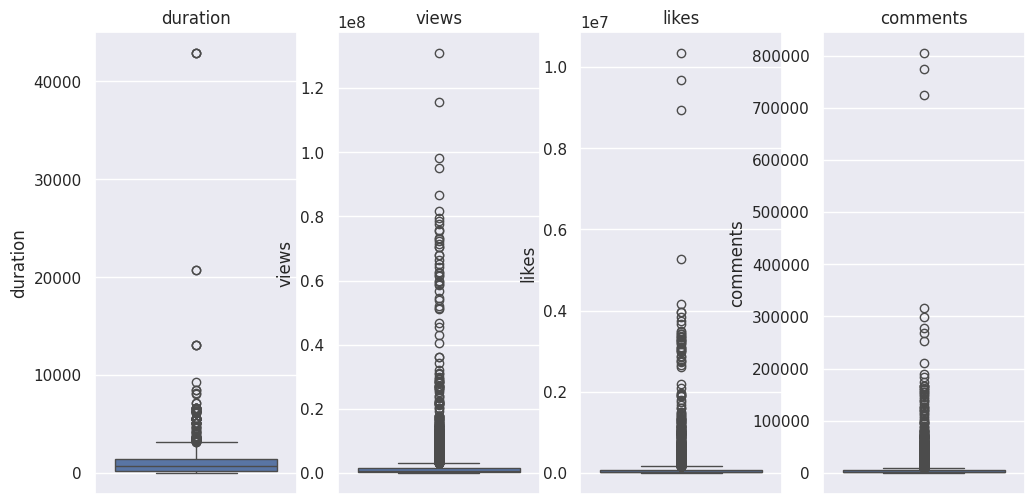

In [17]:
# Viewing outliers
plt.figure(figsize=(12, 6))

for i, var in enumerate(['duration', 'views', 'likes', 'comments']):
    plt.subplot(1, 4, i+1)
    sns.boxplot(df[var])
    plt.title(var)

plt.show()

We can see similarities on the largest values of views, likes and comments. Let's take a closer look at the videos.


In [18]:
def view_top(var):
    return df.sort_values(var, ascending=False).head(10)

In [19]:
view_top('views')

,video_id,trending_date,publish_date,title,duration,views,likes,comments
304,QdBZY2fkU-0,2023-12-09,2023-12-04,Grand Theft Auto VI Trailer 1,91,130932243,10348208,804902
204,QdBZY2fkU-0,2023-12-07,2023-12-04,Grand Theft Auto VI Trailer 1,91,115562103,9693470,773881
154,QdBZY2fkU-0,2023-12-06,2023-12-04,Grand Theft Auto VI Trailer 1,91,98233194,8943681,723821
4736,tWYsfOSY9vY,2024-03-07,2024-03-02,I Survived 7 Days In An Abandoned City,1e+03,95130709,4164983,155703
4663,tWYsfOSY9vY,2024-03-06,2024-03-02,I Survived 7 Days In An Abandoned City,1e+03,86801341,3977107,149704
2933,krsBRQbOPQ4,2024-01-31,2024-01-27,"$1 vs $250,000,000 Private Island!",1e+03,81546291,3474804,78837
3629,KOEfDvr4DcQ,2024-02-14,2024-02-10,"Face Your Biggest Fear To Win $800,000",1.3e+03,79541018,3500245,138546
2190,ZHhqwBwmRkI,2024-01-14,2024-01-10,Still Here | Season 2024 Cinematic - League of...,2.6e+02,78727897,1515548,35316
4552,tWYsfOSY9vY,2024-03-05,2024-03-02,I Survived 7 Days In An Abandoned City,1e+03,77796936,3752802,141792
1599,K_CbgLpvH9E,2024-01-04,2023-12-30,I Spent 7 Days In Solitary Confinement,1.2e+03,75886697,3342501,63154


In [20]:
view_top('likes')

,video_id,trending_date,publish_date,title,duration,views,likes,comments
304,QdBZY2fkU-0,2023-12-09,2023-12-04,Grand Theft Auto VI Trailer 1,91,130932243,10348208,804902
204,QdBZY2fkU-0,2023-12-07,2023-12-04,Grand Theft Auto VI Trailer 1,91,115562103,9693470,773881
154,QdBZY2fkU-0,2023-12-06,2023-12-04,Grand Theft Auto VI Trailer 1,91,98233194,8943681,723821
101,QdBZY2fkU-0,2023-12-05,2023-12-04,Grand Theft Auto VI Trailer 1,91,36095030,5260883,45824
4736,tWYsfOSY9vY,2024-03-07,2024-03-02,I Survived 7 Days In An Abandoned City,1e+03,95130709,4164983,155703
4663,tWYsfOSY9vY,2024-03-06,2024-03-02,I Survived 7 Days In An Abandoned City,1e+03,86801341,3977107,149704
1300,lOKASgtr6kU,2023-12-29,2023-12-23,I Rescued 100 Abandoned Dogs!,9e+02,72814563,3969889,79888
1255,lOKASgtr6kU,2023-12-28,2023-12-23,I Rescued 100 Abandoned Dogs!,9e+02,68084449,3838368,77191
4552,tWYsfOSY9vY,2024-03-05,2024-03-02,I Survived 7 Days In An Abandoned City,1e+03,77796936,3752802,141792
265,lOKASgtr6kU,2023-12-27,2023-12-23,I Rescued 100 Abandoned Dogs!,9e+02,61787326,3661736,73929


In [21]:
view_top('comments')

,video_id,trending_date,publish_date,title,duration,views,likes,comments
304,QdBZY2fkU-0,2023-12-09,2023-12-04,Grand Theft Auto VI Trailer 1,91,130932243,10348208,804902
204,QdBZY2fkU-0,2023-12-07,2023-12-04,Grand Theft Auto VI Trailer 1,91,115562103,9693470,773881
154,QdBZY2fkU-0,2023-12-06,2023-12-04,Grand Theft Auto VI Trailer 1,91,98233194,8943681,723821
2111,8R1_TqU68yo,2024-01-13,2024-01-09,Goodbye Internet,1.5e+03,15108872,1916622,315323
1572,8R1_TqU68yo,2024-01-12,2024-01-09,Goodbye Internet,1.5e+03,13767545,1806019,298870
944,PzdbOj84gTo,2023-12-21,2023-12-18,MI ULTIMO VIDEO / Kimberly Loaiza,9.3e+02,10346532,969453,277141
1329,8R1_TqU68yo,2024-01-11,2024-01-09,Goodbye Internet,1.5e+03,11820381,1605858,268998
875,PzdbOj84gTo,2023-12-20,2023-12-18,MI ULTIMO VIDEO / Kimberly Loaiza,9.3e+02,9107326,909453,253829
3133,5ZKLM5pNoGQ,2024-02-04,2024-02-02,Drippy (Official Video) | Sidhu Moose Wala | M...,2e+02,7822841,1248367,211396
3064,5ZKLM5pNoGQ,2024-02-03,2024-02-02,Drippy (Official Video) | Sidhu Moose Wala | M...,2e+02,5263601,1043396,190563


'Grand Theft Auto VI Trailer 1' is bay far the most viewed, liked and commented video of the last few months. This is the most significant outlier video on all three variables.

'I Survived 7 Days In An Abandoned City' comes second in views and likes but falls short in comments. Even though it is not among the most viewed or liked, 'Goodbye Internet' is the second most commented video. After reviewing the comments, it's evident that this particular video has evoked an emotional response from viewers.

In [22]:
view_top('duration')

,video_id,trending_date,publish_date,title,duration,views,likes,comments
274,rsfZvzjSXW0,2023-12-27,2023-12-25,🔥 Cozy Fireplace 4K (12 HOURS). Fireplace with...,4.3e+04,563034,1381,65
1175,rsfZvzjSXW0,2023-12-26,2023-12-25,🔥 Cozy Fireplace 4K (12 HOURS). Fireplace with...,4.3e+04,489599,1212,38
1257,rsfZvzjSXW0,2023-12-28,2023-12-25,🔥 Cozy Fireplace 4K (12 HOURS). Fireplace with...,4.3e+04,577023,1450,69
4788,BOBQQ9vD_-E,2024-03-08,2024-03-06,Jerry After Dark: Breaking Caitlin Clark's Sco...,2.1e+04,326917,4594,129
4705,BOBQQ9vD_-E,2024-03-07,2024-03-06,Jerry After Dark: Breaking Caitlin Clark's Sco...,2.1e+04,318704,4544,111
338,Zu2z5M4gmno,2023-12-10,2023-12-08,THE GAME AWARDS 2023: Official 4K Livestream (...,1.3e+04,6383394,198344,4839
285,Zu2z5M4gmno,2023-12-09,2023-12-08,THE GAME AWARDS 2023: Official 4K Livestream (...,1.3e+04,6112551,194689,4430
408,Zu2z5M4gmno,2023-12-11,2023-12-08,THE GAME AWARDS 2023: Official 4K Livestream (...,1.3e+04,6523115,200439,5079
2892,A5AV0-NrIFc,2024-01-30,2024-01-29,Unc & Ocho react to Patrick Mahomes leading Ch...,9.3e+03,845431,30567,2151
488,5QbP5YwGsT4,2023-12-12,2023-12-09,ESTATE SALE Cadillac EFI V8-6-4 | Will it RUN ...,8.5e+03,1146216,51989,8640


Ranging from 10 seconds to several hours, the duration variable has a large range of values. However, the most significant outlier is the 12-hour video of a fireplace posted on Christmas Day.

<a id='section2'></a>
## 2. How are the variables correlated with each other?

In this section we take a quick look at how views, likes, comments and duration are correlated with each other.

We start by plotting a correlation matrix to get a general view.

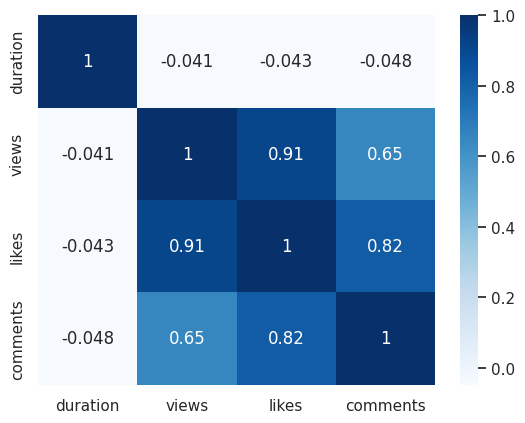

In [23]:
# Correlation matrix
sns.heatmap(df[['duration', 'views', 'likes', 'comments']].corr(), annot=True, cmap='Blues')
plt.show()

Duration does not seem to have a significant connection to other variables. We'll focus on the pairwise relationships of the remaining three by viewing scatter plots.

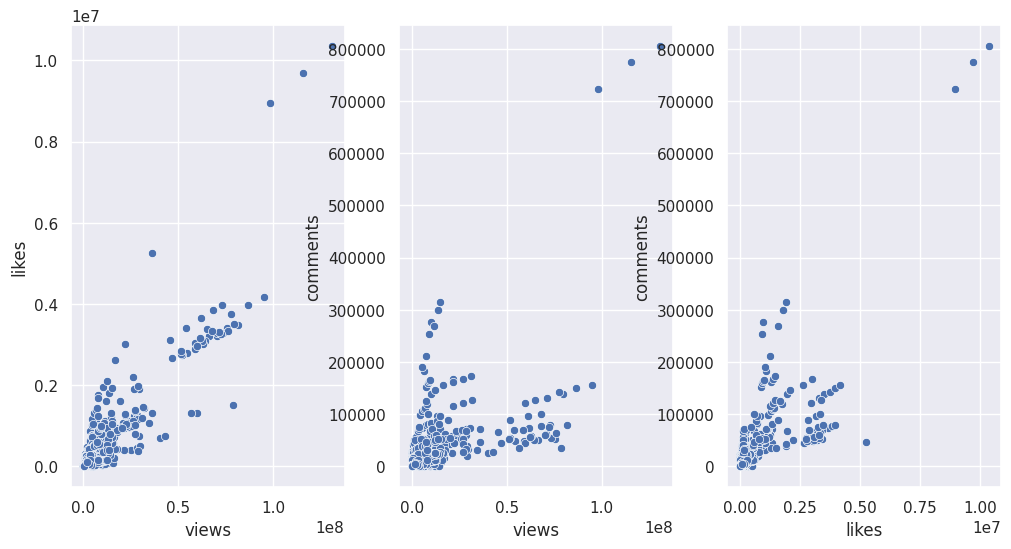

In [24]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='views', y='likes')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df, x='views', y='comments')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df, x='likes', y='comments')

plt.show()

We can recognize the three points at the top right corner from before; this is 'Grand Theft Auto VI Trailer 1', the most viewed and engaged video of the past months. Let's get a better view on the remaining points by removing this video.

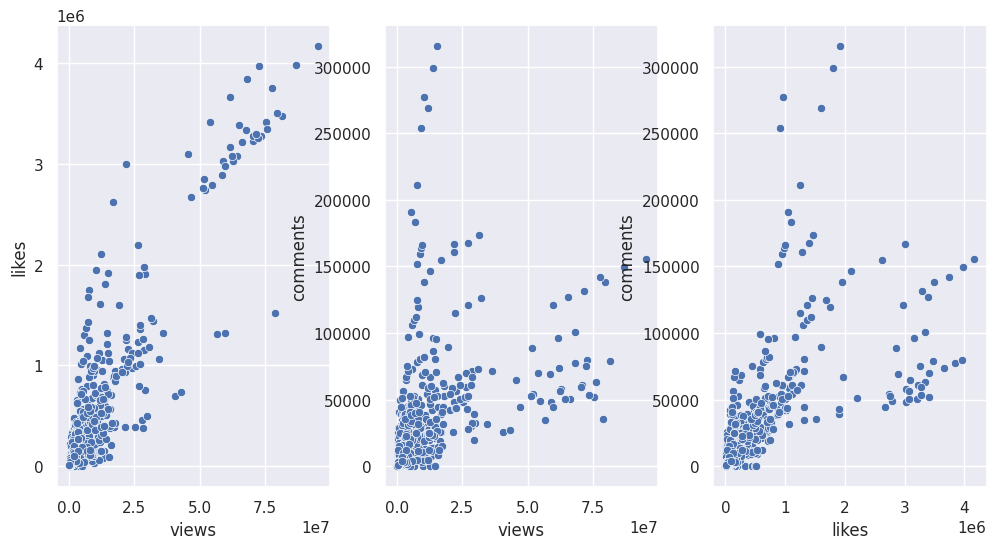

In [25]:
df_no_gta = df.copy()[df['video_id'] != 'QdBZY2fkU-0']

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(data=df_no_gta, x='views', y='likes')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df_no_gta, x='views', y='comments')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df_no_gta, x='likes', y='comments')

plt.show()

The correlation between views and likes is the strongest; it seems comments have a more localized relationship with the other two variables.

<a id='section3'></a>
## 3. Are there any time points where the variables fluctuated significantly?

In this section we'll analyze fluctuations in views, likes and comments over time.

We want to take averages over each day and observe the trends over the few months our data set spans. We have observed a lot of outliers in these variables, so we'll choose the median as our way of averaging.

In [26]:
medians = df.groupby('trending_date')[['views', 'likes', 'comments']].agg('median')

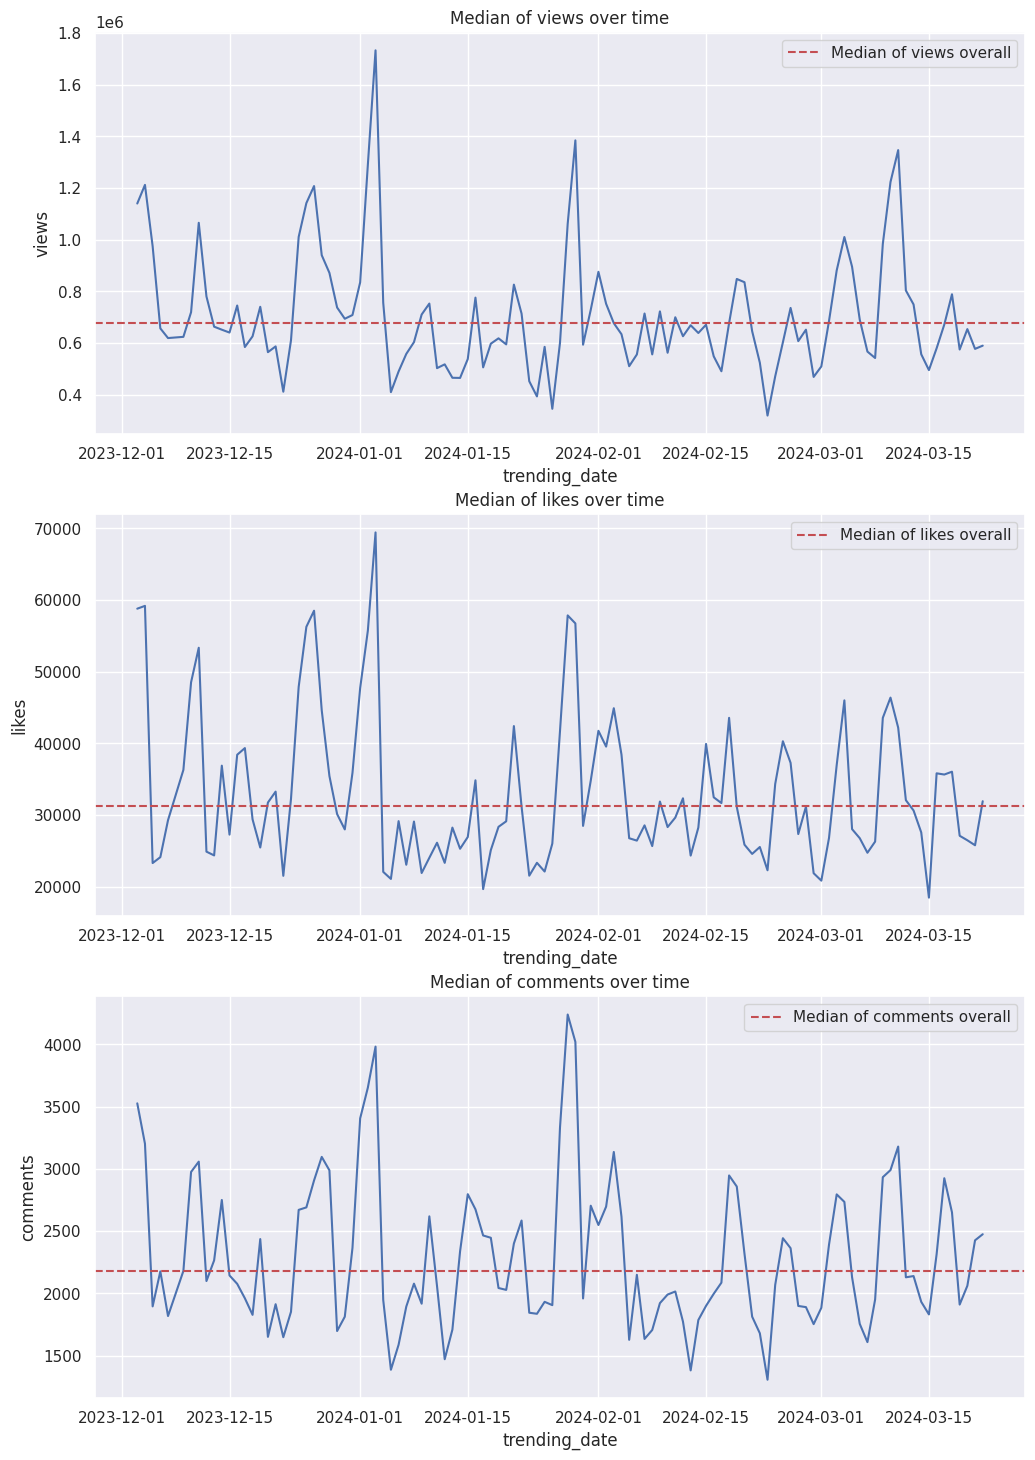

In [27]:
plt.figure(figsize=(12, 24))

for i, var in enumerate(['views', 'likes', 'comments']):
    plt.subplot(4, 1, i+1)
    sns.lineplot(data=medians, x='trending_date', y=var)
    plt.axhline(y=df[var].median(), color='r', ls='--',
                label=f"Median of {var} overall")
    plt.title(f"Median of {var} over time")
    plt.legend()

plt.show()

We can see spikes at similar times on our graphs. In order to take a closer look at these points, we'll make comparisons using tables that include the quantiles for the overall data, and the data belonging to the days where spikes occur.

In [28]:
# Explore days with spikes in a given variable
def view_median_spikes(var, threshold):
    days = medians[medians[var] > threshold].index
    print(f"Distribution of {var} overall and on days with median spikes")

    all = df.describe().loc[['max', '75%', '50%', '25%', 'min'], [var]]

    for d in days:
        new_col = df[df['trending_date'] == d].describe() \
            .loc[['max', '75%', '50%', '25%', 'min'], [var]]
        all = pd.concat([all, new_col], axis=1)

    all.columns = ['overall'] + [d.date() for d in days]

    return all

In [29]:
view_median_spikes('views', 1300000)

Distribution of views overall and on days with median spikes


,overall,2024-01-03,2024-01-29,2024-03-11
max,1.3e+08,7.1e+07,5.9e+07,1.4e+07
75%,1.5e+06,2.8e+06,2.6e+06,2.8e+06
50%,6.8e+05,1.7e+06,1.4e+06,1.3e+06
25%,3.6e+05,9.4e+05,5.3e+05,6.6e+05
min,5e+04,1.5e+05,1.5e+05,2.7e+05


January 3 has the largest spike in median of views. We can observe that this is caused by the lower range of values.

In [30]:
view_median_spikes('likes', 60000)

Distribution of likes overall and on days with median spikes


,overall,2024-01-03
max,1e+07,3.2e+06
75%,7.6e+04,1.3e+05
50%,3.1e+04,6.9e+04
25%,1.5e+04,2.4e+04
min,5.3e+02,2.9e+03


January 3 has the largest spike in likes median too. We can observe a more significant increase in the values around the median compared to the quartiles.

In [31]:
view_median_spikes('comments', 3500)

Distribution of comments overall and on days with median spikes


,overall,2023-12-03,2024-01-02,2024-01-03,2024-01-28,2024-01-29
max,8e+05,7.2e+04,5.8e+04,6.1e+04,4.2e+04,6.9e+04
75%,4.9e+03,6.5e+03,6e+03,6.6e+03,8.5e+03,8.7e+03
50%,2.2e+03,3.5e+03,3.7e+03,4e+03,4.2e+03,4e+03
25%,1.1e+03,1.6e+03,1.6e+03,1.8e+03,2e+03,1.7e+03
min,0,2.2e+02,3e+02,3.2e+02,5.3e+02,3.1e+02


January 3 is in this list as well, although the largest spikes are on January 28 and 29. This time we see a more significant difference in the number of values between the medians and the third quartiles.

It appears that the videos trending on January 3 have the highest median views and engagement. This suggests a surge in YouTube usage following the conclusion of the holiday season, indicating heightened activity among users.

<a id='section4'></a>
## 4. Are there any particular days that stand out as optimal for video publishing?

We now examine whether the day of the week influences views, likes and comments, across both trending and posting times of the videos.

In [32]:
df['publish_day'] = df['publish_date'].dt.day_name()

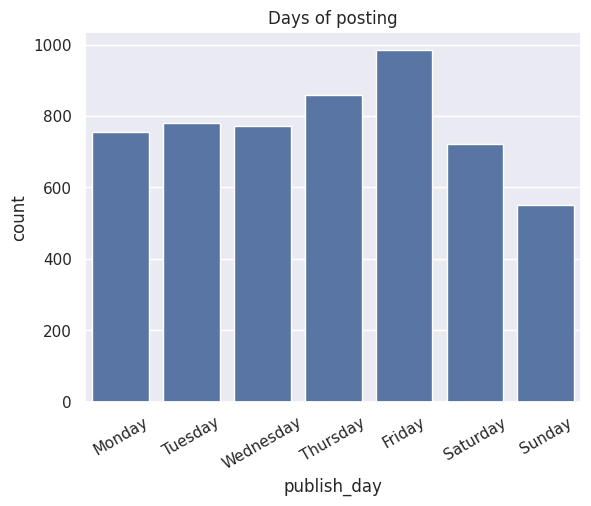

In [33]:
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.countplot(data=df, x='publish_day', order=week)
plt.xticks(rotation=30)
plt.title('Days of posting')
plt.show()

Friday is the top choice for posting videos followed by Thursday, and Sunday is the least used day. Let's see if we can observe a similar distribution elsewhere in our database.

We will examine how views, likes, and comments vary based on the days of the week and the days chosen for posting videos.

In [34]:
df['trending_day'] = df['trending_date'].dt.day_name()

In [35]:
def gp_publish(var):
    var_publish_day = df.groupby('publish_day')[[var]].agg(['sum'])
    var_publish_day.columns = var_publish_day.columns.droplevel(0)
    m = var_publish_day['sum'].max()
    return var_publish_day, m

In [36]:
def gp_trending(var):
    var_trending_day = df.groupby('trending_day')[[var]].agg(['sum'])
    var_trending_day.columns = var_trending_day.columns.droplevel(0)
    m = var_trending_day['sum'].max()
    return var_trending_day, m

In [37]:
def plot_gps(var, y_upper=0):
    gp1, m1 = gp_trending(var)
    gp2, m2 = gp_publish(var)
    y_upper = max(max(m1, m2), y_upper)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(data=gp1,
                x=gp1.index, y='sum',
                order=week)
    plt.xticks(rotation=30)
    plt.ylim([0, y_upper])
    plt.title(f"Total {var} by day")

    plt.subplot(1, 2, 2)
    sns.barplot(data=gp2,
                x=gp2.index, y='sum',
                order=week)
    plt.xticks(rotation=30)
    plt.ylim([0, y_upper])
    plt.title(f"Total {var} by post day")

    plt.show()

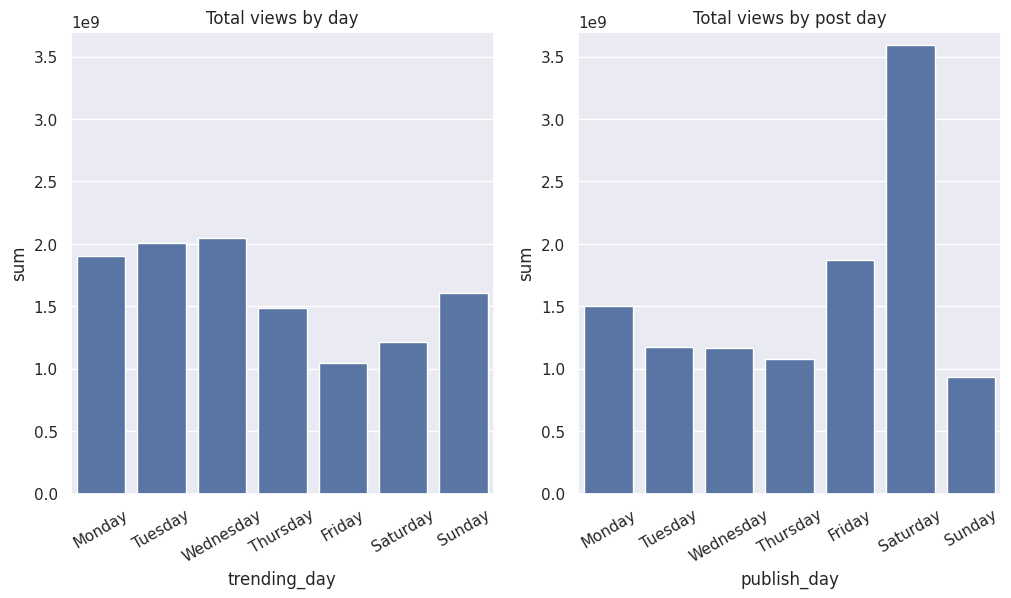

In [38]:
plot_gps('views', 3.7e9)

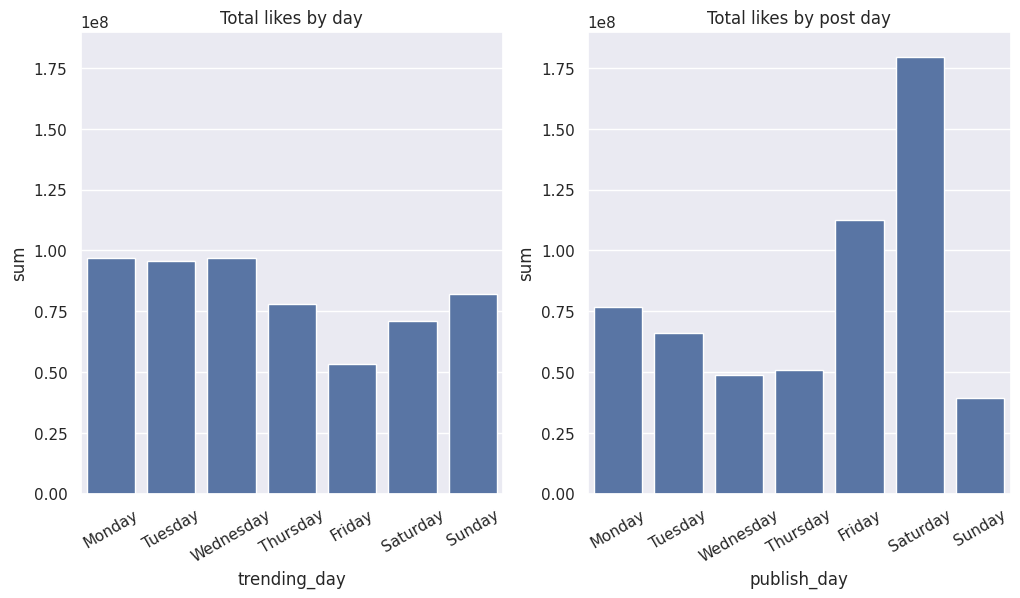

In [39]:
plot_gps('likes', 1.9e8)

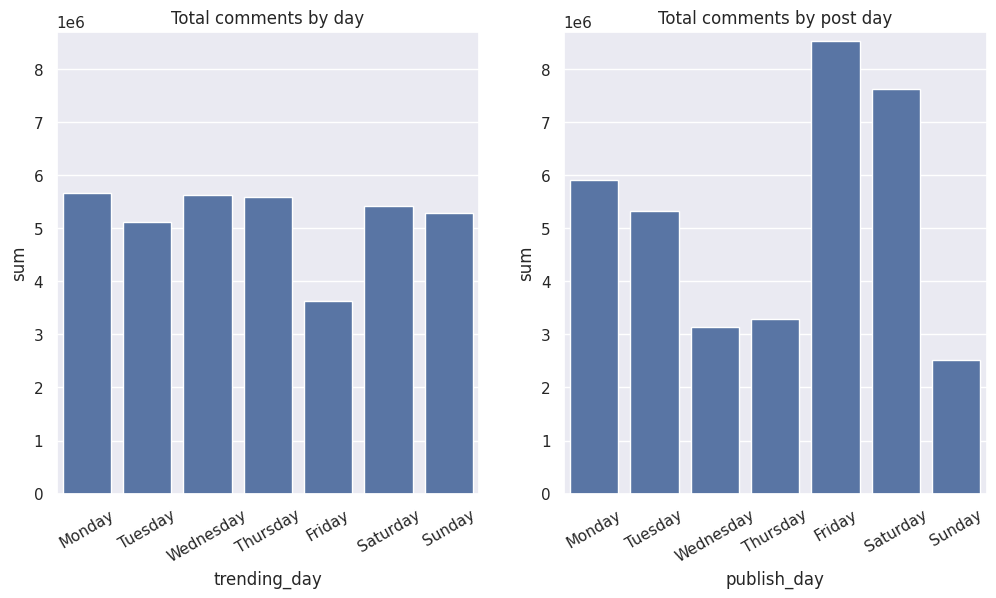

In [40]:
plot_gps('comments', 8.7e6)

Interaction with trending videos tends to dip to a minimum on Fridays, gradually recovering over the weekend, and reaching a peak during the initial weekdays. Specifically, Tuesday has the highest number of views, while Monday has the most comments.

Notably, videos posted three days prior, particularly on Friday and Saturday, receive substantially more views and engagement. It's interesting to observe that Saturday is as the optimal day for maximum views and likes, whereas videos uploaded on Friday receive the highest number of comments.